In [21]:
#Import libraries
import requests
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.10.0


In [22]:
LEARNING_RATE = 0.006738550781435328 
EPOCH = 700
BATCH_SIZE = 16

In [23]:
#GRAIN_TYPE = 'Wheat'
GRAIN_TYPE = 'Combined_Grains'
FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + 'classifyVariety.h5'
URL = "../../Datasets/processed/" + GRAIN_TYPE + ".csv"
df = pd.read_csv(URL)
# Convert to numpy array
#df = df.groupby('Variety').head(120)
df_features = df[[ 
                    'Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    ]]

df_targets = df[['Grain Type']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
scaler = StandardScaler()
dataset_x = scaler.fit_transform(dataset_x)
dataset_y = df_targets.to_numpy()

In [24]:
from sklearn.preprocessing import LabelEncoder

# Getting the number of unique varieties
num_varieties = df_targets['Grain Type'].nunique()
varieties = df_targets['Grain Type'].unique()
print(f'There are {num_varieties} different varieties.')

# Encode the 'variety' labels
label_encoder = LabelEncoder()
# Step 1: Convert varieties into number ex. 1 2 3... and store in a single list
integer_encoded = label_encoder.fit_transform(df_targets['Grain Type'])
# Step 2: Get the number of different classes
depth = num_varieties
# Step 3: Pass in the list of numerical values and the number of classes and vectors are created 
#         For example the value 4 would be passed and converted to [0. 0. 0. 0. 1.]
one_hot_encoded = tf.one_hot(integer_encoded, depth)
# Step 4: Convert to numpy arr
y_one_hot = one_hot_encoded.numpy()  # If using TensorFlow's one_hot


There are 5 different varieties.


In [25]:
'''
Uncomment this to have the dataset split be uniform in test set but not train set, no val included.
'''

# from sklearn.model_selection import train_test_split
# import tensorflow as tf

# # Assume other parts of the code (dataset_x, y_integers, depth) are defined as in previous examples

# # Perform stratified train-test split on the data to maintain class distribution
# X_train, X_temp, y_train_integer, y_temp_integer = train_test_split(
#     dataset_x, integer_encoded, test_size=0.20, stratify=integer_encoded, random_state=42
# )
# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the training set
# y_train = tf.one_hot(y_train_integer, depth).numpy()

# # Now create a balanced test set from X_temp and y_temp_integer
# unique_classes = np.unique(y_train_integer)
# samples_per_class = min(np.bincount(y_temp_integer))  # Find the smallest class size in the test set

# # Create a list to store the sampled indices
# indices_to_keep = []

# for cls in unique_classes:
#     # Get the indices for each class
#     class_indices = np.where(y_temp_integer == cls)[0]
#     # Randomly choose 'samples_per_class' indices from each class
#     chosen_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)
#     indices_to_keep.extend(chosen_indices)

# # Use the indices to create the balanced test set
# X_test = X_temp[indices_to_keep]
# y_test_integer = y_temp_integer[indices_to_keep]

# # Convert the integer labels back to one-hot encoding for TensorFlow/Keras for the test set
# y_test = tf.one_hot(y_test_integer, depth).numpy()


'\nUncomment this to have the dataset split be uniform in test set but not train set, no val included.\n'

In [26]:

unique, counts = np.unique(integer_encoded, return_counts=True)
min_class_size = min(counts)
print(f"Minimum class size: {min_class_size}")

# Calculate the number of samples for each class in the train and test sets
# Here we are assuming an 80-20 split, adjust these values as necessary
train_samples_per_class = int(min_class_size * 0.8)
test_samples_per_class = min_class_size - train_samples_per_class

# Initialize lists to store the training and test indices
train_indices = []
test_indices = []

# Sample indices for the train and test sets
for cls in unique:
    # Get the indices for each class
    class_indices = np.where(integer_encoded == cls)[0]
    
    # Shuffle class indices to randomize selection
    np.random.shuffle(class_indices)
    
    # Split class indices into train and test samples
    train_indices.extend(class_indices[:train_samples_per_class])
    test_indices.extend(class_indices[train_samples_per_class:train_samples_per_class + test_samples_per_class])

# Shuffle the train and test indices to mix the classes
np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Create the balanced train and test sets
X_train = dataset_x[train_indices]
y_train_integer = integer_encoded[train_indices]
X_test = dataset_x[test_indices]
y_test_integer = integer_encoded[test_indices]

# Convert the integer labels back to one-hot encoding for TensorFlow/Keras
y_train = tf.one_hot(y_train_integer, depth).numpy()
y_test = tf.one_hot(y_test_integer, depth).numpy()

Minimum class size: 366


In [27]:
def print_dataset_split(y_train_integer,y_test_integer):
    # Create a DataFrame for the training set class distribution
    train_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_train_integer)),
        'Train': np.bincount(y_train_integer)
    })

    # Create a DataFrame for the balanced test set class distribution
    test_counts = pd.DataFrame({
        'Class Name': label_encoder.inverse_transform(np.unique(y_test_integer)),
        'Test': np.bincount(y_test_integer)
    })

    # Merge the two DataFrames on Class Name
    combined_counts = pd.merge(train_counts, test_counts, on='Class Name', how='outer').fillna(0)

    # Converts to integer type
    combined_counts['Train'] = combined_counts['Train'].astype(int)
    combined_counts['Test'] = combined_counts['Test'].astype(int)

    # Set display options for pandas
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.colheader_justify', 'center')
    pd.set_option('display.precision', 3)

    # Print combined class counts in a tabular format
    print(combined_counts.to_string(index=False, justify='right'))


In [28]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define model
model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(256, activation='relu'),
    
    Dense(5, activation='softmax')  # Changed to softmax for multi-class
])

# Compile model with per-class precision and recall
metrics = ['accuracy']  # General accuracy for all classes

# Add precision and recall for each class
for i in range(depth):
    metrics.append(tf.keras.metrics.Precision(class_id=i, name=f'precision_class_{i}'))
    metrics.append(tf.keras.metrics.Recall(class_id=i, name=f'recall_class_{i}'))

model.compile(
    loss='categorical_crossentropy',  # Correct loss for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),  
    metrics=metrics
)
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
model.save(FILENAME_BEST_MODEL)

Epoch 1/700
92/92 [==============================] - 0s 690us/step - loss: 1.0264 - accuracy: 0.5329 - precision_class_0: 0.7037 - recall_class_0: 0.3253 - precision_class_1: 0.7919 - recall_class_1: 0.4041 - precision_class_2: 0.8593 - recall_class_2: 0.7945 - precision_class_3: 0.5579 - recall_class_3: 0.1815 - precision_class_4: 0.2500 - recall_class_4: 0.0171                                  
Epoch 2/700
92/92 [==============================] - 0s 643us/step - loss: 0.9112 - accuracy: 0.5856 - precision_class_0: 0.7486 - recall_class_0: 0.4486 - precision_class_1: 0.8824 - recall_class_1: 0.4623 - precision_class_2: 0.8860 - recall_class_2: 0.8253 - precision_class_3: 0.6533 - recall_class_3: 0.4452 - precision_class_4: 0.3846 - recall_class_4: 0.0856 
Epoch 3/700
92/92 [==============================] - 0s 643us/step - loss: 0.8130 - accuracy: 0.6459 - precision_class_0: 0.7585 - recall_class_0: 0.5377 - precision_class_1: 0.8974 - recall_class_1: 0.4795 - precision_class_2: 0.912

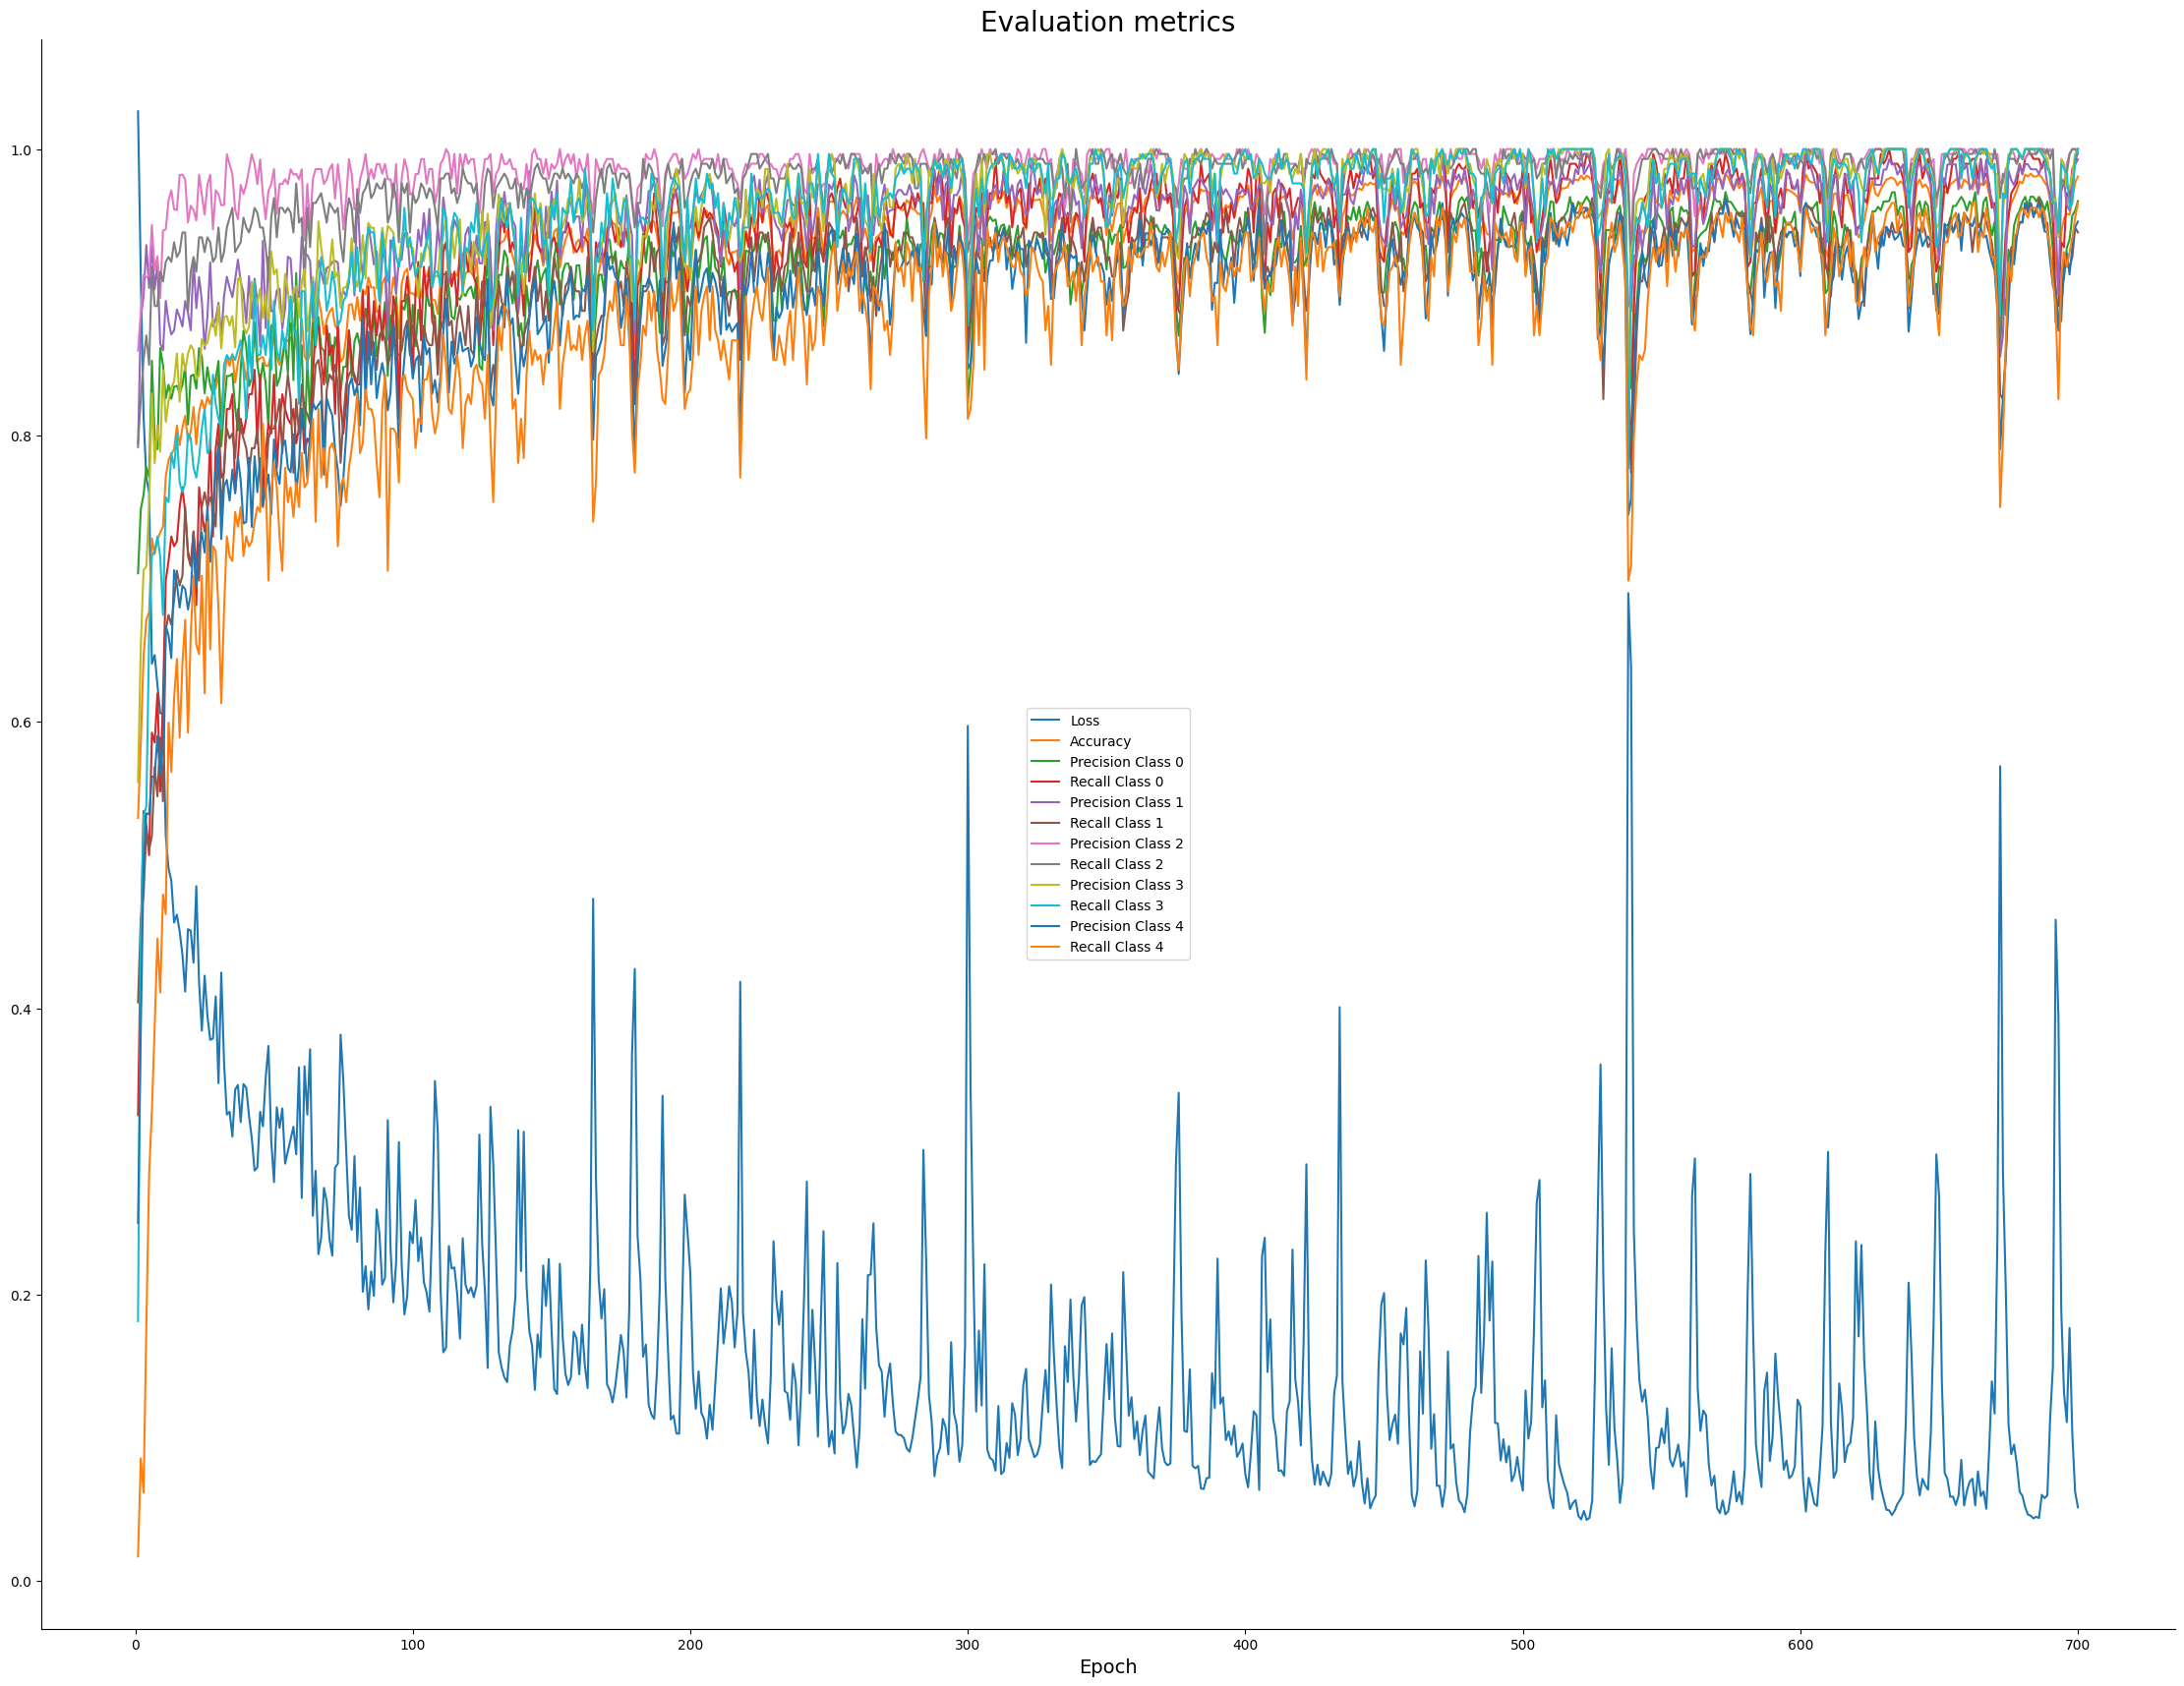

In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['figure.figsize'] = (28, 21)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# Correcting the range of epochs to match the actual number of epochs trained
epochs_trained = len(history.history['loss']) 

# Plot Loss and Accuracy
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, epochs_trained + 1),
    history.history['accuracy'], label='Accuracy'
)

# Plot Precision and Recall for each class
num_classes = 5  # Update this with the actual number of classes you have
for i in range(num_classes):
    precision_label = f'precision_class_{i}'
    recall_label = f'recall_class_{i}'
    
    # Check if precision and recall for each class are in history to avoid KeyError
    if precision_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[precision_label], label=f'Precision Class {i}'
        )
    if recall_label in history.history:
        plt.plot(
            np.arange(1, epochs_trained + 1),
            history.history[recall_label], label=f'Recall Class {i}'
        )

plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()


In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy, *test_metrics = model.evaluate(X_test, y_test,verbose=0)
y_pred = model.predict(X_test,verbose=0)

# Assuming the order of metrics is consistent with how we added them:
# test_metrics[0] -> precision_class_0, test_metrics[1] -> recall_class_0, etc.
metrics_per_class = {
    'Loss': test_loss,
    'Accuracy': test_accuracy,
}

num_classes = 5  # Update this with the actual number of classes you have
class_names = label_encoder.inverse_transform(np.unique(y_train_integer))

def compute_confusion_matrix(true, pred):
    classes = np.unique(true)
    conf_mat = [[0] * len(classes) for i in range(len(classes))]
    for i in range(len(true)):
        conf_mat[pred[i]][true[i]]+=1
    print("       Actual")
    print("      _",end="")
    for item in classes:
        print("____",end="")
    print()
    print("pred  |", end=" "),
    for item in classes:
        print("{:^3}".format(item), end=" ")
    print()
    for item in classes:
        print("{:^6}|".format(item), end=" ")
        for item2 in classes:
            print("{:^3}".format(conf_mat[item][item2]), end="|")
        print()
def compute_metrics_per_class(true, pred, test_metrics):
    classes = np.unique(true)
    conf_mat = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(true)):
        conf_mat[pred[i], true[i]] += 1

    num_classes = len(classes)
    max_class_name_length = max(len(name) for name in class_names)
    
    total_precision = 0
    total_recall = 0
    total_accuracy = 0

    for i in range(num_classes):
        precision = float(test_metrics[2 * i])  # Even indices for precision
        recall = float(test_metrics[2 * i + 1])  # Odd indices for recall
        accuracy = float(conf_mat[i, i]) / np.sum(conf_mat[:, i])  # Calculate accuracy for class i
        
        total_precision += precision
        total_recall += recall
        total_accuracy += accuracy

        print(f"{class_names[i]:<{max_class_name_length}} | Precision: {precision:.3f} | Recall: {recall:.3f} | Accuracy: {accuracy:.3f}")

    # Calculate and print the averages
    avg_precision = total_precision / num_classes
    avg_recall = total_recall / num_classes
    avg_accuracy = total_accuracy / num_classes
    print(f"\nAvg Precision: {avg_precision:.3f} | Avg Recall: {avg_recall:.3f} | Avg Accuracy: {avg_accuracy:.3f}")

y_pred_labels = np.argmax(y_pred, axis=1)
y_test_nums = np.argmax(y_test, axis=1)
print_dataset_split(y_train_integer,y_test_integer)
print()
print("=================================================================")

compute_confusion_matrix(y_test_nums.tolist(),y_pred_labels.tolist())
print()
print("=================================================================")
compute_metrics_per_class(y_test_nums.tolist(),y_pred_labels.tolist(),test_metrics)
print("HYPERPARAMS: LR:",LEARNING_RATE," EPOCH:",EPOCH," BATCH:",BATCH_SIZE)
print("=================================================================")


Class Name  Train  Test
    Barley    292    74
      Corn    292    74
      Oats    292    74
   Sorghum    292    74
     Wheat    292    74

       Actual
      _____________________
pred  |  0   1   2   3   4  
  0   | 65 | 3 | 3 | 2 | 9 |
  1   |  3 |65 | 0 | 1 | 6 |
  2   |  1 | 1 |71 | 0 | 2 |
  3   |  1 | 1 | 0 |70 | 1 |
  4   |  4 | 4 | 0 | 1 |56 |

Barley  | Precision: 0.793 | Recall: 0.878 | Accuracy: 0.878
Corn    | Precision: 0.867 | Recall: 0.878 | Accuracy: 0.878
Oats    | Precision: 0.947 | Recall: 0.959 | Accuracy: 0.959
Sorghum | Precision: 0.959 | Recall: 0.946 | Accuracy: 0.946
Wheat   | Precision: 0.875 | Recall: 0.757 | Accuracy: 0.757

Avg Precision: 0.888 | Avg Recall: 0.884 | Avg Accuracy: 0.884
HYPERPARAMS: LR: 0.006738550781435328  EPOCH: 700  BATCH: 16
